In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import itertools

import getpass
username = getpass.getuser()

%matplotlib inline

In [31]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
data = data[data['Condition']=='80-20']


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [32]:
def Xy_history(data, X_dataframe='switch', y_dataframe='switch'):
    #include past 10 choice and reward values (this is most convenient given the current data structure)
    port_features = []
    reward_features = []
    for col in data.columns:
        if '_Port' in col:
            port_features.append(col)
        if '_Reward' in col:
            reward_features.append(col)

    choice_history = data[port_features]
    reward_history = data[reward_features]

    switch_cols = ['9_Switch','8_Switch','7_Switch','6_Switch','5_Switch','4_Switch','3_Switch','2_Switch','1_Switch']
    switch_history = pd.DataFrame(np.abs(np.diff((choice_history))))
    switch_history.columns=switch_cols
    switch_history.index=reward_history.index

    if X_dataframe == 'choice':
        X = pd.concat([choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)
    elif X_dataframe == 'switch':
        X = pd.concat([switch_history, reward_history.drop('10_Reward', axis=1)], axis=1)
    elif X_dataframe == 'choice_switch':
        X = pd.concat([switch_history, choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)
    elif X_dataframe == 'value':
        X = (choice_history.values==reward_history.values).astype('int') # gives action value with R=1, L=0

    if y_dataframe == 'switch':
        y = data['Switch']
    elif y_dataframe == 'choice':
        y = data['Decision']
        
    return X, y


In [33]:
X_switch, y_switch = Xy_history(data)

In [43]:
def sequences_predict_switch(X, y, sequence_length=3, display=True):
    
    switch_reward_mat = X[['3_Switch','2_Switch','1_Switch','3_Reward','2_Reward','1_Reward']]
    reward_combos = list(itertools.product([0,1], repeat=sequence_length*2, ))
    
    switch_reward_sequence = []
    for i in range(len(X)):
        switch_reward_sequence.append(np.where(np.sum(reward_combos==switch_reward_mat.values[i], axis=1)==6)[0][0])
        
    idx=[] # create vector with indices for where each sequence in reward combos occurs in test
    for i in range(len(reward_combos)):
        idx.append(np.where([switch_reward_sequence[n]==i for n in range(len(switch_reward_sequence))])[0])
        
    prob_switch_counts = np.array([len(idx[i]) for i in range(len(reward_combos))])

    prob_switch=np.zeros(len(reward_combos))
    for i in range(len(reward_combos)):
        if prob_switch_counts[i]==0:
            prob_switch[i] = 0
        else:
            prob_switch[i] = y.iloc[idx[i]].sum()/len(idx[i]) 
    
    if display==True:
        prob_switch=np.array(prob_switch)
        idx = prob_switch.argsort()
        reward_combos_sorted=np.array(reward_combos)[idx]
        prob_switch_sorted=prob_switch[idx]
        prob_switch_counts_sorted=prob_switch_counts[idx]

        reward_intensity = [reward_combos_sorted[i][3:6].sum() for i in range(len(reward_combos_sorted))]
        colors_dict={0:'whitesmoke', 1:'silver', 2:'dimgray', 3:'black'}
        colors = [colors_dict[reward_intensity[i]] for i in range(len(reward_intensity))]

        plt.figure(figsize=(20,8))
        plt.bar(left=np.arange(len(reward_combos)) ,height=prob_switch_sorted, color=colors)
        plt.xticks(range(len(reward_combos)), reward_combos_sorted, rotation='vertical')
        plt.ylabel('p_switch')
        plt.xlabel('sequence - switch, reward')
        print()
        plt.legend(colors_dict, loc='upper left')

        for i in range(len(reward_combos)):
            plt.text(x = np.arange(len(reward_combos))[i]-.4 , y = prob_switch_sorted[i]+0.01, 
             s = "{:.1f}".format((prob_switch_counts_sorted[i]/prob_switch_counts.sum())*100), size = 8)
      
    return reward_combos, prob_switch    
        

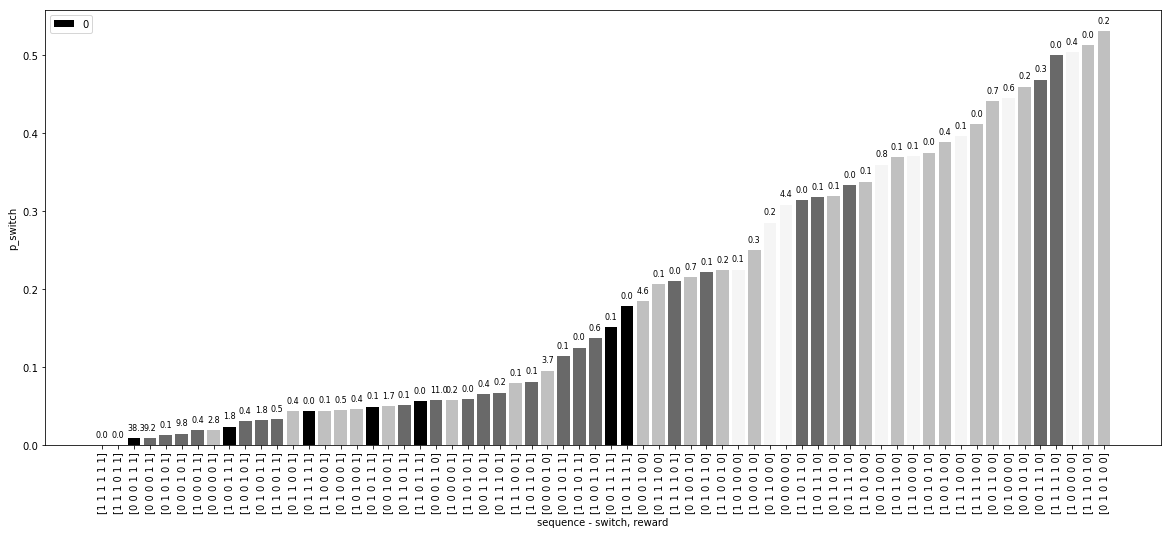

In [44]:
reward_combos, prob_switch = sequences_predict_switch(X_switch, y_switch)

### plot p(switch) after n-3 sequence with color coding for reward history

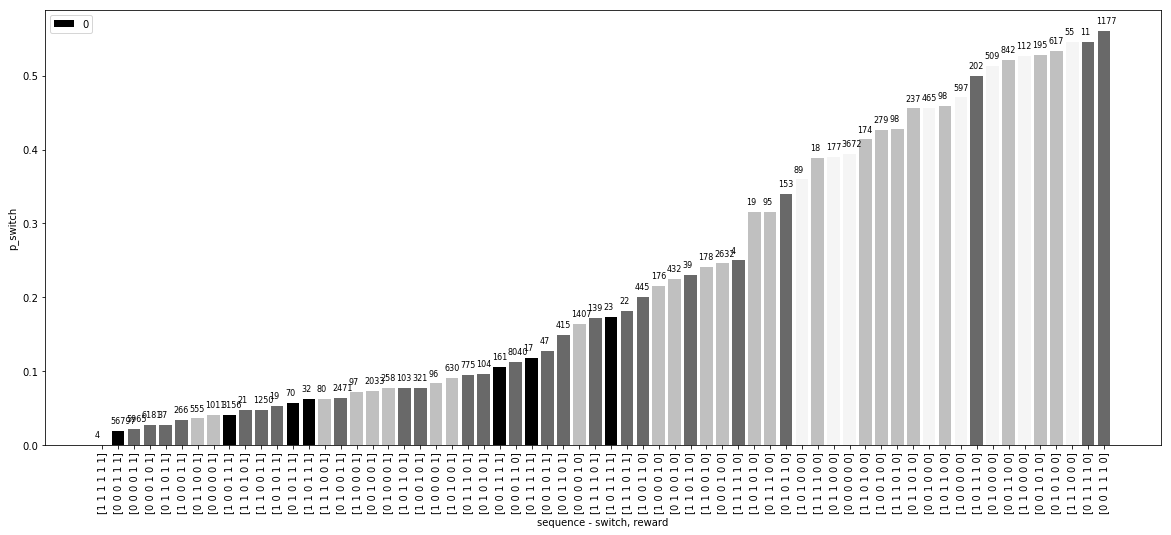

In [545]:
prob_switch=np.array(prob_switch)
idx = prob_switch.argsort()
reward_combos_sorted=np.array(reward_combos)[idx]
prob_switch_sorted=prob_switch[idx]
prob_switch_counts_sorted=prob_switch_counts[idx]

reward_intensity = [reward_combos_sorted[i][3:6].sum() for i in range(len(reward_combos_sorted))]
colors_dict={0:'whitesmoke', 1:'silver', 2:'dimgray', 3:'black'}
colors = [colors_dict[reward_intensity[i]] for i in range(len(reward_intensity))]

plt.figure(figsize=(20,8))
plt.bar(left=np.arange(len(reward_combos)) ,height=prob_switch_sorted, color=colors)
plt.xticks(range(len(reward_combos)), reward_combos_sorted, rotation='vertical')
plt.ylabel('p_switch')
plt.xlabel('sequence - switch, reward')
print()
plt.legend(colors_dict, loc='upper left')

for i in range(len(reward_combos)):
    plt.text(x = np.arange(len(reward_combos))[i]-.5 , y = prob_switch_sorted[i]+0.01, s = str(prob_switch_counts_sorted[i]), size = 8)
 

### plot with color coding for switch history

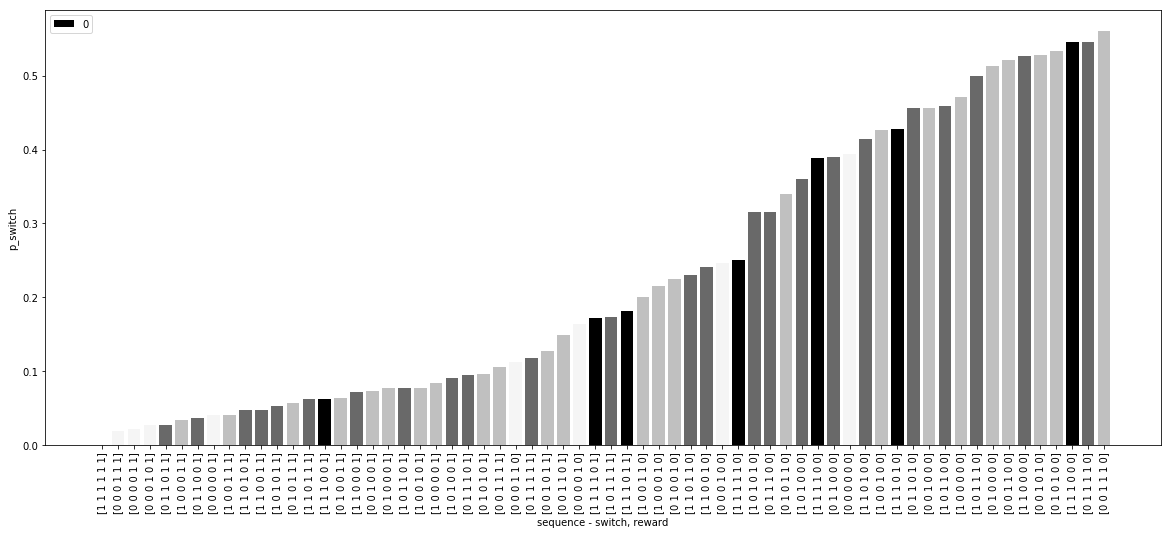

In [546]:
switch_intensity = [reward_combos_sorted[i][0:3].sum() for i in range(len(reward_combos_sorted))]
colors_dict={0:'whitesmoke', 1:'silver', 2:'dimgray', 3:'black'}
colors = [colors_dict[switch_intensity[i]] for i in range(len(reward_intensity))]

plt.figure(figsize=(20,8))
plt.bar(left=np.arange(len(reward_combos)) ,height=prob_switch_sorted, color=colors)
plt.xticks(range(len(reward_combos)), reward_combos_sorted, rotation='vertical')
plt.ylabel('p_switch')
plt.xlabel('sequence - switch, reward')
print()
plt.legend(colors_dict, loc='upper left')

In [547]:
prob_switch_from_half = np.abs(prob_switch-0.5) # acts as kind of a proxy for consistency
prob_switch_from_half.shape

(64,)

### plot as distance from chance to determine consistency

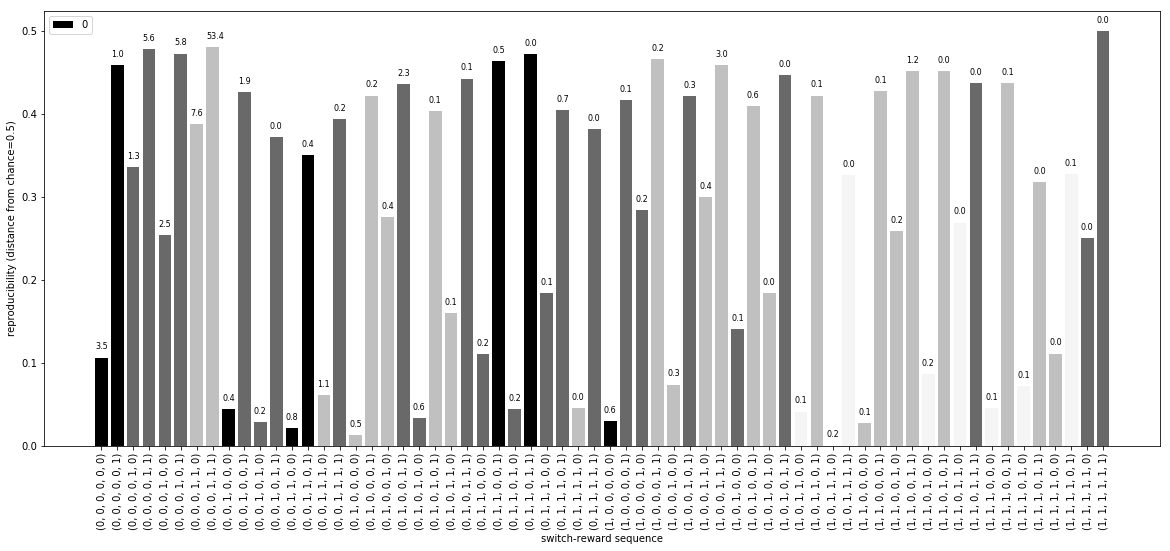

In [548]:
colors = [colors_dict[reward_intensity[i]] for i in range(len(reward_intensity))]

plt.figure(figsize=(20,8))
plt.bar(left=np.arange(len(reward_combos)) ,height=prob_switch_from_half, color=colors)
plt.xticks(range(len(reward_combos)), reward_combos, rotation='vertical')
print()
for i in range(len(reward_combos)):
    plt.text(x = np.arange(len(reward_combos))[i]-.4 , y = prob_switch_from_half[i]+0.01, 
             s = "{:.1f}".format((prob_switch_counts[i]/prob_switch_counts.sum())*100), size = 8)
plt.ylabel('reproducibility (distance from chance=0.5)')
plt.xlabel('switch-reward sequence')
plt.legend(["0","1", "2", "3"] , loc='upper left')